## ml-mipt course

### Seminar 2
### Linear Regression & other stuff

Based on [Evgeny Sokolov](https://github.com/esokolov) open materials.

Let's take a look at Linear Regression and its implementations in this notebook.

__Contents__:
* Linear Regression analytical solution
* Gradient descent approach
* Stochastic gradient
* Model instability in case of multicoolinear features
* Linear Regression out of the box (sklearn, vw, etc.)

In [1]:
%pylab inline
np.random.seed(16)
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


Time to generate features matrix $X$ and correct weights vector $w_{true}$. Targer vector $Y$ is computed as  $Xw_{true}$ with gaussian noise:

In [2]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_0 = np.random.uniform(-2, 2, (n_features))

*Recap:*
Analytical solution formula is simple:

$$
w = (X^TX)^{-1}X^Ty.
$$

Let's check how it works:

In [6]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [7]:
w_star

array([ 0.14076466, -1.53238462])

In [8]:
w_true

array([ 0.12794872, -1.52847346])

As we can see, the analytical solution is quite close to the original one. 

## Градиентный спуск


Здесь присутствует обращение матрицы $X^TX$ — очень трудоёмкая операция при большом количестве признаков. Нетрудно подсчитать, что сложность вычислений $O(d^3 + d^2l)$. При решении задач такая трудоёмкость часто оказывается непозволительной, поэтому параметры ищут итерационными методами, стоимость которых меньше. Один из них — градиентный спуск.

Напомним, что в градиентном спуске значения параметров на следующем шаге получаются из значений параметров на текущем шаге смещением в сторону антиградиента функционала: 

$$w^{(t+1)} = w^{(t)} - \eta_t \nabla Q(w^{(t)}),$$
где $\eta_t$ — длина шага градиентного спуска.

Формула градиента функции ошибки в случае MSE выглядит следующим образом:

$$\nabla Q(w) = -2X^Ty + 2X^TXw = 2X^T(Xw - y).$$
 
Сложность вычислений в данном случае $O(dl)$. Стохастический градиентный спуск отличается от обычного заменой градиента на несмещённую оценку по одному или нескольким объектам. В этом случае сложность становится $O(kd)$, где $k$ — количество объектов, по которым оценивается градиент, $k << l$. Это отчасти объясняет популярность стохастических методов оптимизации.

### Визуализация траекторий GD и SGD
На простом примере разберём основные тонкости, связанные со стохастической оптимизацией.

Обучим на сгенерированных данных линейную регрессию для MSE при помощи полного градиентного спуска — тем самым получим вектор параметров.

Покажем последовательность оценок параметров $w^{(t)}$, получаемых в ходе итераций. Красная точка — $w_{true}$.

In [12]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-2

for i in range(num_steps):
    w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

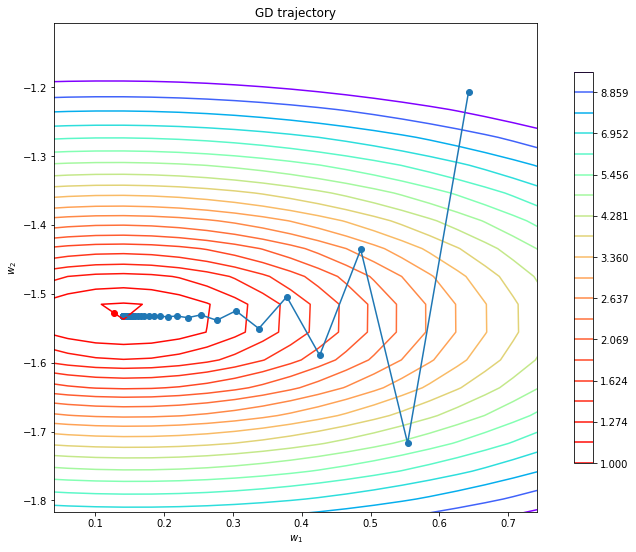

In [13]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('GD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

Чуть ранее мы доказали, что градиент перпендикулярен линиям уровня. Это объясняет такие зигзагообразные траектории градиентного спуска. Для большей наглядности в каждой точке пространства посчитаем градиент функционала и покажем его направление.

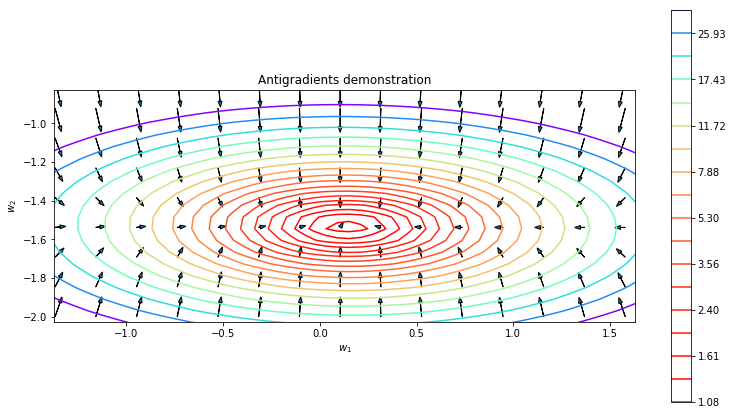

In [14]:
# compute level set
A, B = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
A_mini, B_mini = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 27))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
        
# visualize the level set
plt.figure(figsize=(13, 9))
CS = plt.contour(A, B, levels, levels=np.logspace(-1, 1.5, num=30), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
        
# visualize the gradients
gradients = np.empty_like(A_mini)
for i in range(A_mini.shape[0]):
    for j in range(A_mini.shape[1]):
        w_tmp = np.array([A_mini[i, j], B_mini[i, j]])
        antigrad = - 2*1e-3 * np.dot(X.T, np.dot(X, w_tmp) - Y) / Y.shape[0]
        plt.arrow(A_mini[i, j], B_mini[i, j], antigrad[0], antigrad[1], head_width=0.02)

plt.title('Antigradients demonstration')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_true[0] - 1.5, w_true[0] + 1.5))
plt.ylim((w_true[1] - .5, w_true[1] + .7))
plt.gca().set_aspect('equal')
plt.show()

Визуализируем теперь траектории стохастического градиентного спуска, повторив те же самые действия, оценивая при этом градиент по подвыборке.

In [15]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 0.2

for i in range(num_steps):
    sample = np.random.randint(n_objects, size=batch_size)
    w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

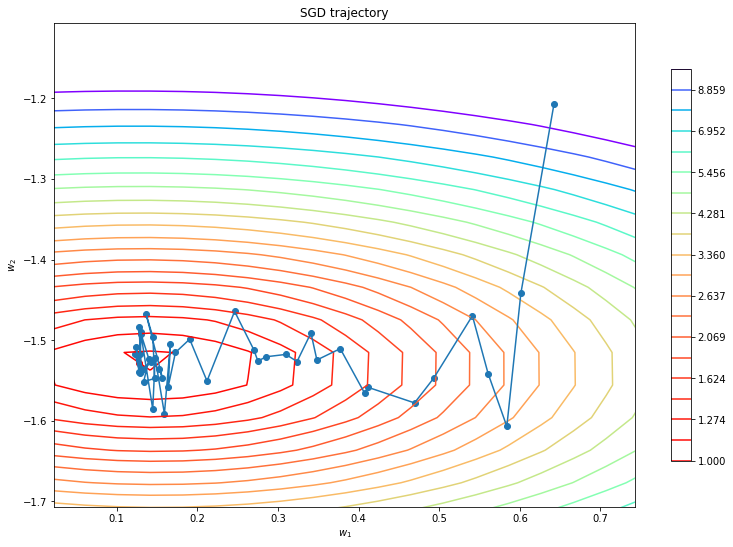

In [16]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

Как видно, метод стохастического градиента «бродит» вокруг оптимума. Это объясняется подбором шага градиентного спуска $\eta_k$. Дело в том, что для сходимости стохастического градиентного спуска для последовательности шагов $\eta_k$ должны выполняться [условия Роббинса-Монро](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586):
$$
\sum_{k = 1}^\infty \eta_k = \infty, \qquad \sum_{k = 1}^\infty \eta_k^2 < \infty.
$$
Интуитивно это означает следующее: 
1. последовательность должна расходиться, чтобы метод оптимизации мог добраться до любой точки пространства, 
2. но расходиться не слишком быстро.

Попробуем посмотреть на траектории SGD, последовательность шагов которой удовлетворяет условиям Роббинса-Монро:

In [17]:
w = w_0.copy()
w_list = [w.copy()]
step_size_0 = 0.45

for i in range(num_steps):
    step_size = step_size_0 / ((i+1)**0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

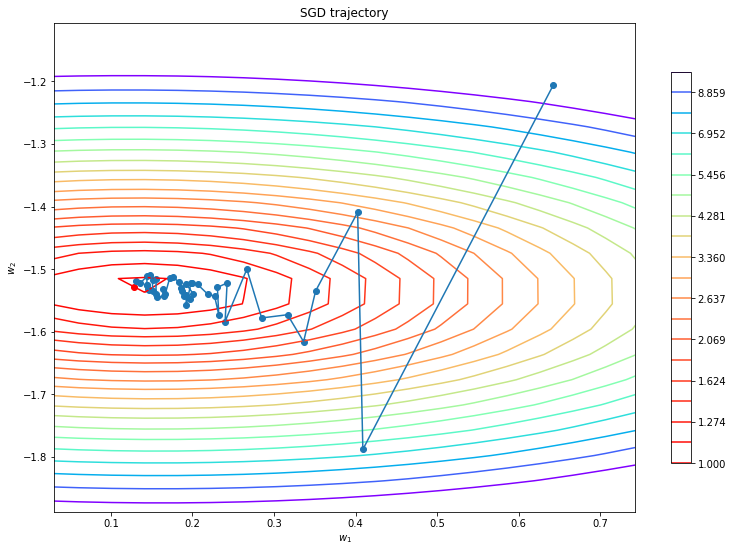

In [18]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
#plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

### Сравнение скоростей сходимости

Последнее, что хотелось бы продемонстрировать — сравнение, насколько быстро достигают оптимума метод полного и стохастического градиентного спуска. Сгенерируем выборку и построим график зависимости функционала от итерации.

In [19]:
# data generation
n_features = 50
n_objects = 1000
num_steps = 200
batch_size = 2

w_true = np.random.uniform(-2, 2, n_features)

X = np.random.uniform(-10, 10, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 5, n_objects)

In [20]:
step_size_sgd = 1
step_size_gd = 1e-2
w_sgd = np.random.uniform(-4, 4, n_features)
w_gd = w_sgd.copy()
residuals_sgd = [np.mean(np.power(np.dot(X, w_sgd) - Y, 2))]
residuals_gd = [np.mean(np.power(np.dot(X, w_gd) - Y, 2))]

for i in range(num_steps):
    step_size = step_size_sgd / ((i+1) ** 0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w_sgd -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w_sgd) - Y[sample]) / Y.shape[0]
    residuals_sgd.append(np.mean(np.power(np.dot(X, w_sgd) - Y, 2)))
    
    w_gd -= 2 * step_size_gd * np.dot(X.T, np.dot(X, w_gd) - Y) / Y.shape[0]
    residuals_gd.append(np.mean(np.power(np.dot(X, w_gd) - Y, 2)))

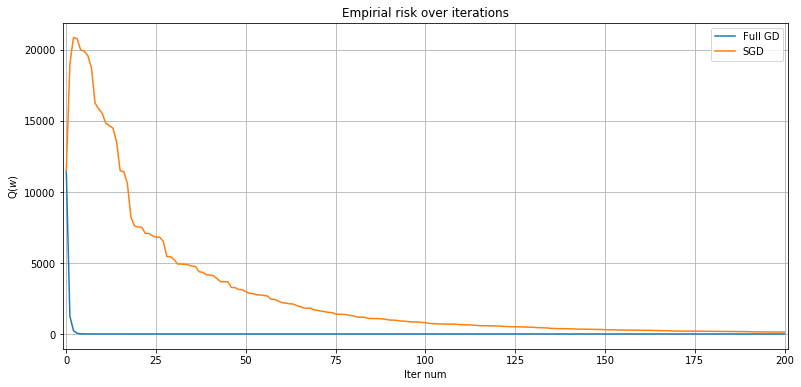

In [21]:
plt.figure(figsize=(13, 6))
plt.plot(range(num_steps+1), residuals_gd, label='Full GD')
plt.plot(range(num_steps+1), residuals_sgd, label='SGD')
plt.title('Empirial risk over iterations')
plt.xlim((-1, num_steps+1))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'Q($w$)')
plt.grid()
plt.show()

Как видно, GD буквально за несколько итераций оказывается вблизи оптимума, в то время как поведение SGD может быть весьма нестабильным. Как правило, для более сложных моделей наблюдаются ещё большие флуктуации в зависимости качества функционала от итерации при использовании стохастических градиентных методов. Путём подбора величины шага можно добиться лучшей скорости сходимости, и существуют методы, адаптивно подбирающие величину шага (AdaGrad, Adam, RMSProp).

### Multicollinearity

In case of multicollinear (or highly correlated) features presence the vanilla linear models tends to suffer.

In [217]:
def visualise(mu, sigma, points, x_ticklabels=None, title=None, greater_than_zero=False):
    if greater_than_zero:
        mu = np.clip(mu, 0, mu.max())
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    plt.plot(points, mu, "r", label="mean value")
    _x = np.concatenate((points, points[::-1]))
    _y = np.concatenate(([mu[i] - sigma[i] for i in range(len(points))], 
                            [mu[i] + sigma[i] for i in range(len(points)-1, -1, -1)]))
    if greater_than_zero:
        _y = np.clip(_y, 0., _y.max())
    plt.fill(_x, _y, fc='r', alpha=.2, ec=None, label='+- sigma range')
    
    if x_ticklabels is not None:
        ax.set_xticks(np.arange(len(x_ticklabels)))
        ax.set_xticklabels(x_ticklabels)
    
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid()

Let's generate new dataset with correlated features:

In [77]:
n_features = 3
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
X[:, -1] = X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape)
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_0 = np.random.uniform(-2, 2, (n_features))

In [80]:
w_true

array([-1.08959496, -0.55818699,  0.58126693])

In [81]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [82]:
w_star

array([  -1.0788938 , -642.8282845 ,  642.85447727])

As we can see, the second and third coefficents are opposite. This makes our model highly *unstable*.

Same case with the gradient descent method:

In [83]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-3

for i in range(num_steps):
    w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

In [84]:
w_list[-1]

array([-1.29960076,  0.23799926, -0.21393552])

In [85]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 0.2

for i in range(num_steps):
    sample = np.random.randint(n_objects, size=batch_size)
    w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

In [86]:
w_list[-1]

array([  63.50895273, -380.49161172, -380.94588047])

However, regularization can fix it:

In [90]:
w_star = np.linalg.inv(X.T.dot(X) + 0.05*np.eye(n_features)).dot(X.T).dot(Y)

In [91]:
w_star

array([-1.0790951 ,  0.00631212,  0.01978453])

The solution is *unstable*. Let's take a look at the *condition number* of our matrix:

$$\kappa(a) = \frac{\sigma_\max(A)}{\sigma_\min(A)}$$
where $\sigma _{\max }(A)$ and $\sigma _{\min }(A)$ are maximal and minimal singular values of $A$ respectively. Hence

In [95]:
def get_w_by_grad(X, Y, num_steps, w_0, step_size):
    w = w_0.copy()

    for i in range(num_steps):
        w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    return w

In [199]:
def get_w_by_stoch_grad(X, Y, num_steps, w_0, step_size_0, n_objects):
    w = w_0.copy()
    step_size_0 = 0.45

    for i in range(num_steps):
        step_size = step_size_0 / ((i+1)**0.51)
        sample = np.random.randint(n_objects, size=batch_size)
        w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    return w

In [97]:
def rmse(y_true, y_pred):
    return np.linalg.norm(y_true-y_pred)

In [200]:
step_size = 1e-3
sgd_step_size = 0.1
num_steps = 250
noise_eps_seq = np.linspace(1e-2, 7e-7, 20)

In [201]:
condition_numbers = []
vector_norms_list = []
rmse_list = []
for eps in noise_eps_seq:
    local_condition_numbers = []
    local_vector_norms_list = []
    local_rmse_list = []
    for i in range(50):
        X[:, -1] = 2 * (X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape))

        a = np.linalg.eigvals(X.T.dot(X))
        local_condition_numbers.append(a.max()/a.min())

        w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
        w_star_grad = get_w_by_grad(X, Y, num_steps, w_0, step_size)
        w_star_sgd = get_w_by_stoch_grad(X, Y, num_steps, w_0, sgd_step_size, n_objects)
        local_vector_norms_list.append([
            np.linalg.norm(w_star),
            np.linalg.norm(w_star_grad), 
            np.linalg.norm(w_star_sgd)
        ])

        analytical_predict = X.dot(w_star)
        grad_predict = X.dot(w_star_grad)
        sgd_predict = X.dot(w_star_sgd)
        
        local_rmse_list.append([
            rmse(Y, analytical_predict),
            rmse(Y, grad_predict),
            rmse(Y, sgd_predict)
        ])

    condition_numbers.append([np.mean(local_condition_numbers), np.std(local_condition_numbers)])
    vector_norms_list.append([
        np.mean(np.array(local_vector_norms_list), axis=0),
        np.std(np.array(local_vector_norms_list), axis=0)
                             ])
    rmse_list.append(np.mean(np.array(local_rmse_list), axis=0))

condition_numbers = np.array(condition_numbers)
vector_norms_list = np.array(vector_norms_list)
rmse_list = np.array(rmse_list)

Let's take a look on the collected numbers

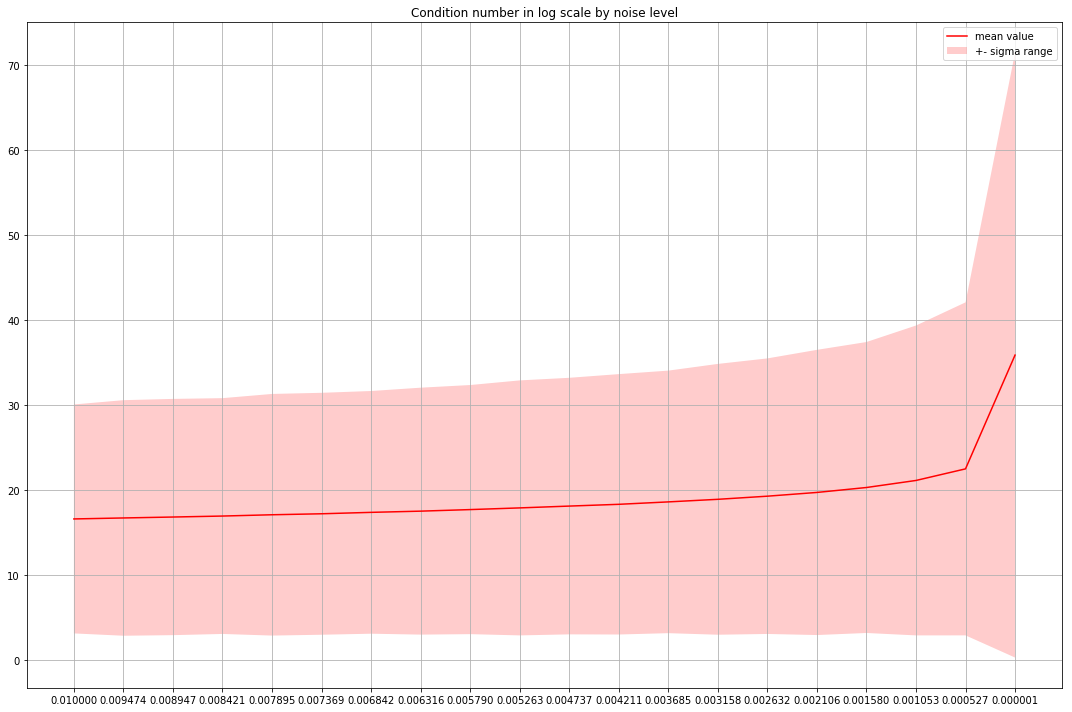

In [218]:
visualise(
    np.log(condition_numbers[:, 0]), 
    np.log(condition_numbers[:, 1]),
    np.arange(len(noise_eps_seq)), 
    ['{0:.6f}'.format(x) for x in noise_eps_seq],
    title='Condition number in log scale by noise level',
    greater_than_zero=True
)

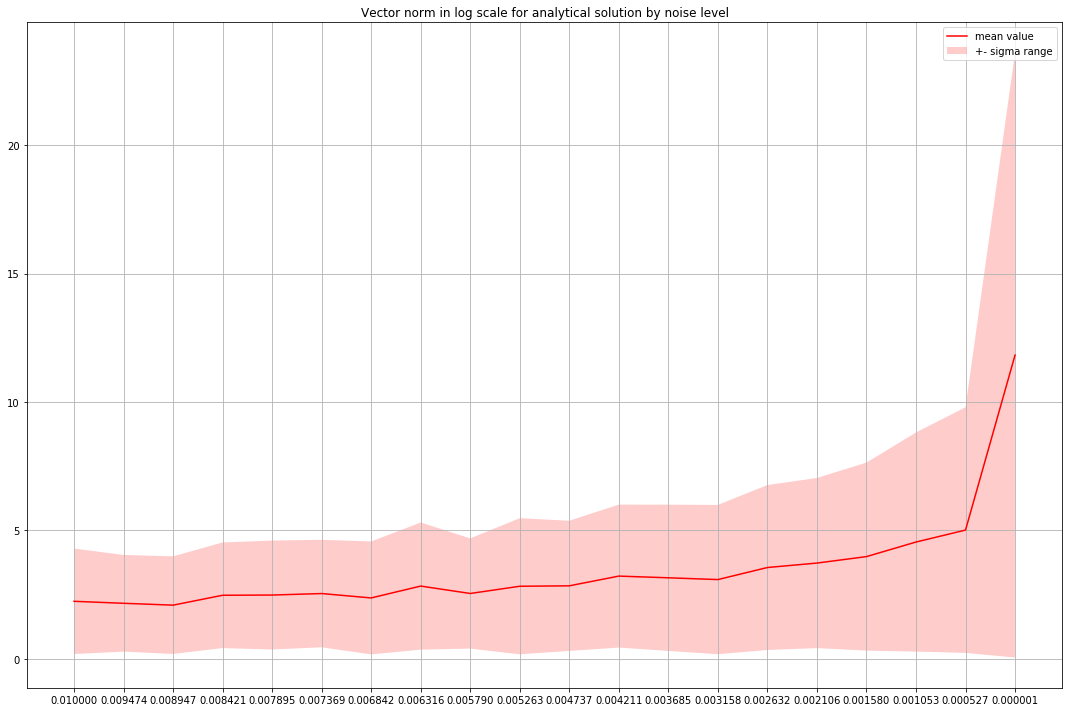

In [219]:
visualise(
    np.log(vector_norms_list[:, 0, 0]), 
    np.log(vector_norms_list[:, 1, 0]),
    np.arange(len(noise_eps_seq)), 
    ['{0:.6f}'.format(x) for x in noise_eps_seq],
    title='Vector norm in log scale for analytical solution by noise level',
    greater_than_zero=True
)

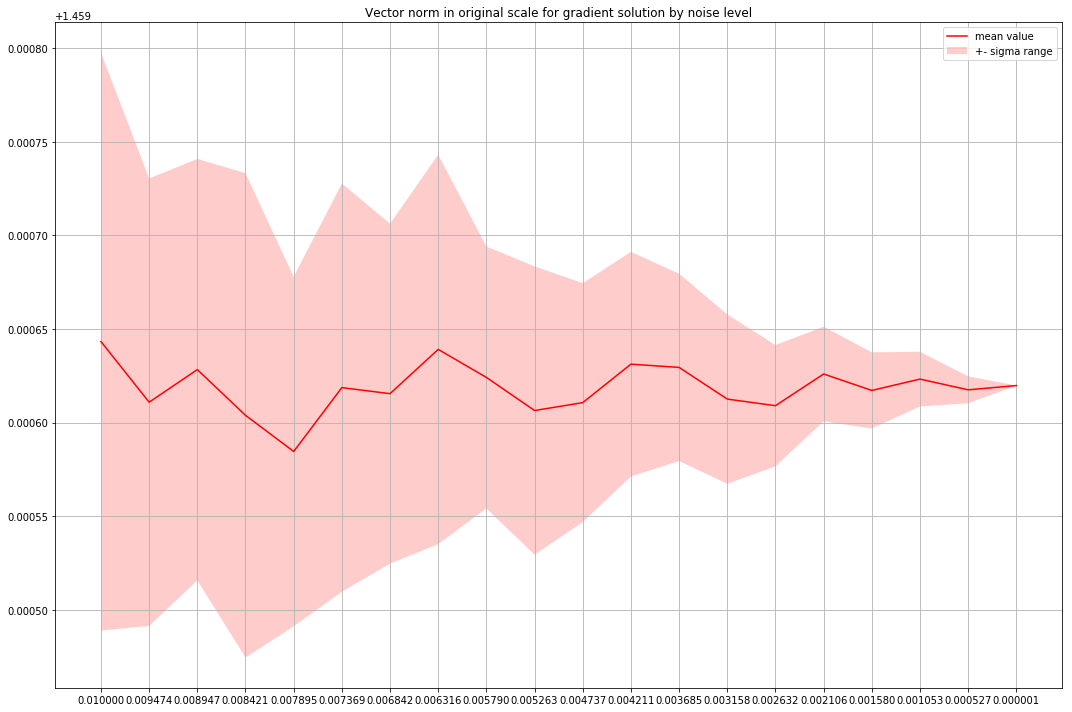

In [220]:
visualise(
    vector_norms_list[:, 0, 1], 
    vector_norms_list[:, 1, 1],
    np.arange(len(noise_eps_seq)), 
    ['{0:.6f}'.format(x) for x in noise_eps_seq],
    title='Vector norm in original scale for gradient solution by noise level',
    greater_than_zero=True
)

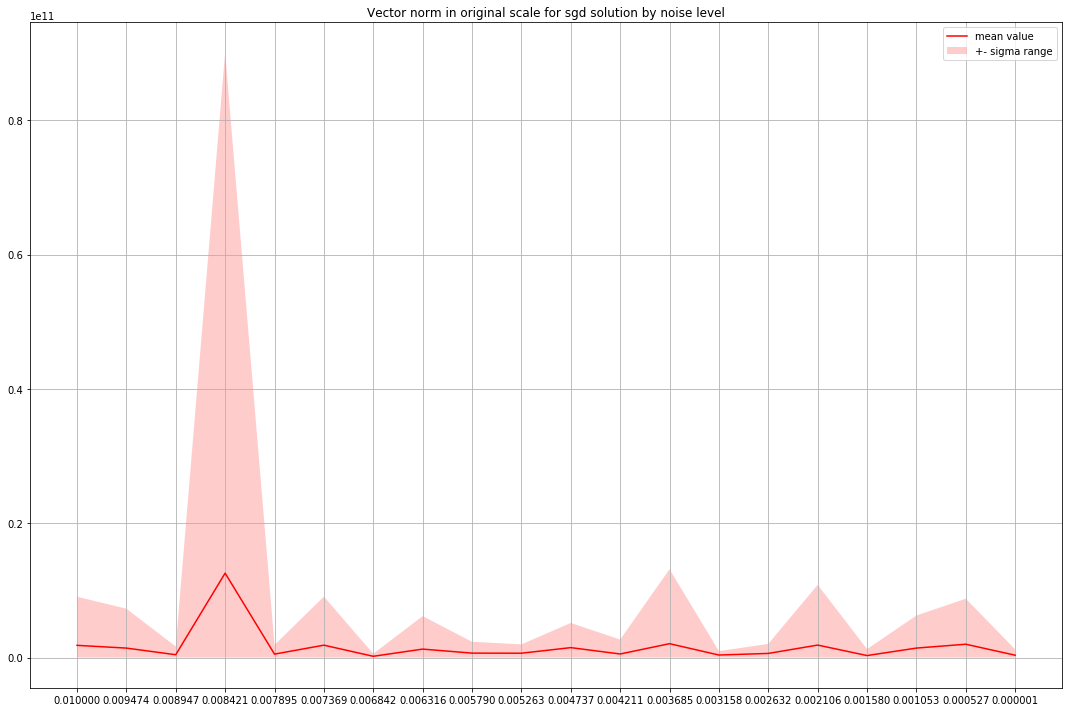

In [221]:
visualise(
    vector_norms_list[:, 0, 2], 
    vector_norms_list[:, 1, 2],
    np.arange(len(noise_eps_seq)), 
    ['{0:.6f}'.format(x) for x in noise_eps_seq],
    title='Vector norm in original scale for sgd solution by noise level',
    greater_than_zero=True
)

### Linear regression out of the box
### Линейная регрессия из коробки

Finally, let's take a brief look at implemented versions of Linear Regression from sklearn. The main classes are:

* [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) — classical linear regression (*actially, it is just `scipy.linalg.lstsq` wrapped with sklearn `Predictor` class) __analytical__ solver.
* [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) — Linear regression with L1 regularization.
* [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) — Linear regression with L2 regularization.

To minimize any other error function you are free to use [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) (or wait a few weeks and we will get the great *PyTorch* automatic differentiation engine).

Let's compare the speed of analytical and gradient solutions from the sklearn realizations. IPython magic `%%time` wrapper will be used. To measure the quality $R^2$ score will be used.
$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2}$$

`LinearRegression` vs. `Ridge`: __Fight!__



![](img/mortal_combat.jpg)

In [222]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [223]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [224]:
%%time

lr = LinearRegression()
lr.fit(X,Y)
print('R2: %f' % lr.score(X,Y))

R2: 0.999969
CPU times: user 19.2 s, sys: 1.06 s, total: 20.3 s
Wall time: 8.02 s


In [225]:
%%time

lr = Ridge(alpha=0.0, solver='sparse_cg')
lr.fit(X,Y)
print('R2: %f' % lr.score(X,Y))

R2: 0.999969
CPU times: user 1.73 s, sys: 434 ms, total: 2.17 s
Wall time: 1.23 s
